##Instalación de librerías
Instalamos las librerías de pandas con los comandos !pip install

---



In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 3.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


##Importación de librerías
Hacemos la importación de las librerías necesarias 

In [3]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from matplotlib import style
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

##Obtenemos los valores del mercado búrsatil
Cambiamos el estilo de trama a ggplot.
Luego usamos pandas_datareader como 'web' para obtener nuestros datos de precios de acciones usando la función DataReader que obtiene los datos financieros y los almacena en pandas.
Obtenemos los datos de acciones de Tesla de 2014 a 2018 para entrenar el modelo.
Obtenemos los datos de acciones de Tesla desde 2019 hasta el día actual para que nuestro modelo haga predicciones.
Utilizarmos la api de yahoo para obtener las acciones TSLA.

In [4]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,30)
df = web.DataReader("TSLA", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end) 

##Ajustando la data
Ordenamos las tablas para que el modelo pueda entrenar con valores secuenciales

In [5]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')
# fix the date
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-21,64.694000,62.487999,63.480000,63.953999,40084000,63.953999
2018-12-24,62.900002,59.040001,62.700001,59.077999,27799500,59.077999
2018-12-26,65.393997,58.818001,60.000000,65.218002,40815500,65.218002
2018-12-27,64.433998,60.299999,63.967999,63.226002,42875500,63.226002
2018-12-28,67.248001,63.681999,64.620003,66.774002,49695000,66.774002


##Ploteando y visualizando los datos
Se traza una media móvil en toda la gráfica. El promedio móvil nos ayuda a suavizar los datos que tienen muchas fluctuaciones y nos ayuda a ver mejor la tendencia a largo plazo.
Con el promedio móvil, puede definir un período de tiempo en el que le gustaría tomar el promedio que se conoce como nuestra ventana. Definimos nuestra ventana de media móvil en 100.

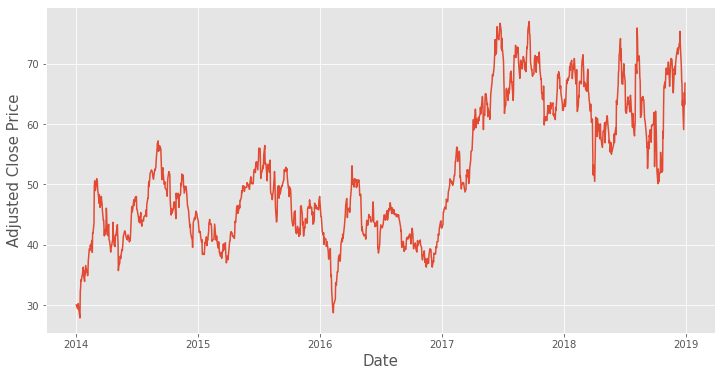

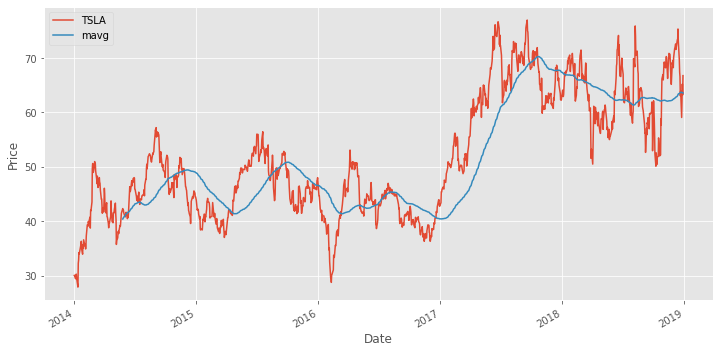

In [6]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

##Convertiendo fechas
Creamos una copia de nuestro marco de datos y lo llamamos dates_df. Almacenamos nuestras fechas originales en org_dates. Usaremos org_dates más adelante para trazar nuestras predicciones y fechas.
A continuación, convertimos nuestras fechas dates_df en números enteros mpara introducir las fechas en las máquinas de vectores de soporte y las redes neuronales.

In [7]:
import matplotlib.dates as mdates
# change the dates into ints for training
dates_df = df.copy()
dates_df = dates_df.reset_index()
# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']
# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)
dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1252,737049.0,64.694000,62.487999,63.480000,63.953999,40084000,63.953999
1253,737052.0,62.900002,59.040001,62.700001,59.077999,27799500,59.077999
1254,737054.0,65.393997,58.818001,60.000000,65.218002,40815500,65.218002
1255,737055.0,64.433998,60.299999,63.967999,63.226002,42875500,63.226002
1256,737056.0,67.248001,63.681999,64.620003,66.774002,49695000,66.774002


##Código SVR usando sklearn y visualizando kernels
Usamos Sklearn y Support Vector Regression (SVR) para predecir los precios en nuestros datos. A pesar de los datos se ajusten bien, lo más probable es que esté sobreajustado. Este modelo tendría dificultades para generalizar en un año de datos de acciones de Tesla no vistos.
Ahí es donde nuestra red neuronal LSTM resulta útil.
Obtenemos nuestros precios y fechas de cierre ajustados como números enteros de nuestros datos. Remodelamos los datos en vectores 1D ya que necesitamos alimentar los datos en el SVR.
Un núcleo es una función para mapear datos de menor dimensión en datos de mayor dimensión..

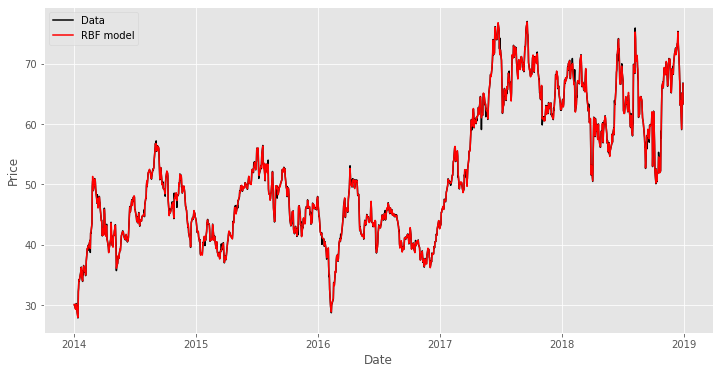

In [8]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR
dates = dates_df['Date'].values
prices = df['Adj Close'].values
#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)
plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

##Normalización de datos
Creamos datos de entrenamiento y los normalizamos.
MinMaxScaler funciona reduciendo el rango de nuestros valores a 0 o 1
A continuación se muestra la ecuación para el escalador min-max:
Esta es la ecuación que sklearn está haciendo en segundo plano para convertir nuestros datos en nuestro rango deseado. Usamos la siguiente fórmula:


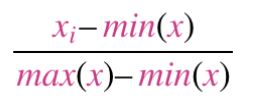

In [9]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].values
print(train_data.shape) # 1258

# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1257,)


##Preparando nuestros datos para la red neuronal
Creamos la función 'create_dataset' para realizar un bucle desde (0 hasta la longitud de nuestro conjunto de datos, el número de pasos de tiempo).
Básicamente, cada índice en la matriz X_train contiene una matriz de 36 días de precios de cierre y la matriz y_train contiene el precio de cierre un día después de nuestros intervalos de tiempo.
Entonces, en otras palabras, alimentamos la red neuronal 36 días de los precios de cierre anteriores de los datos de acciones y luego hacemos que prediga el día siguiente del precio de cierre de las acciones.

In [10]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i + look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)
# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))
print(X_train.shape)

# Visualizing our data with prints:
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1221, 36, 1)
X_train:
[[30.02000046]
 [29.91200066]
 [29.39999962]
 [29.87199974]
 [30.25600052]
 [29.50600052]
 [29.1439991 ]
 [27.86800003]
 [32.25400162]
 [32.82600021]
 [34.19400024]
 [34.0019989 ]
 [35.33599854]
 [35.7120018 ]
 [36.29999924]
 [34.91999817]
 [33.92399979]
 [35.67599869]
 [35.04600143]
 [36.56800079]
 [36.2820015 ]
 [35.42200089]
 [35.74599838]
 [34.88399887]
 [35.67599869]
 [37.30599976]
 [39.31200027]
 [39.32400131]
 [39.06399918]
 [39.92599869]
 [39.64599991]
 [40.74000168]
 [38.72800064]
 [41.99399948]
 [41.91999817]
 [43.52999878]]


y_train: [[49.59999847]]



##Construir el modelo
Construimos nuestra red neuronal como secuencial. Luego creamos dos capas LSTM con un 20 % de abandono después de cada capa.
La primera capa que tenemos return_sequences = true. Hacemos esto porque hemos apilado capas LSTM y queremos que la segunda capa LSTM tenga una entrada de secuencia tridimensional. También tenemos input_shape establecido en nuestra forma x para asegurarnos de que tenga la misma forma 3D de nuestros datos.

In [11]:
# Build the model
model = keras.Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(units = 1))
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
86/86 [==============================] - 16s 60ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 2/20
86/86 [==============================] - 4s 50ms/step - loss: 0.0034 - val_loss: 0.0121
Epoch 3/20
86/86 [==============================] - 4s 50ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 4/20
86/86 [==============================] - 4s 49ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 5/20
86/86 [==============================] - 4s 51ms/step - loss: 0.0027 - val_loss: 0.0138
Epoch 6/20
86/86 [==============================] - 4s 49ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 7/20
86/86 [==============================] - 4s 51ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 8/20
86/86 [==============================] - 4s 51ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 9/20
86/86 [==============================] - 4s 50ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 10/20
86/86 [==============================] - 4s 52ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 11

## Ploteando el modelo de pérdida
Aquí usamos el código de la API de Keras para trazar la pérdida del modelo. A medida que llegamos a la época 20, la pérdida de prueba y la pérdida de tren están muy cerca y se minimizan.

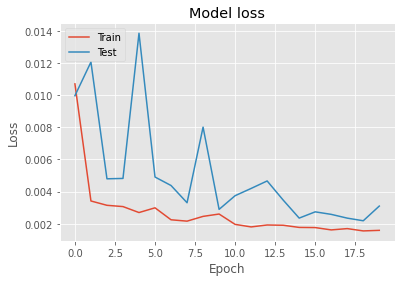

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Haciendo las predicciones
Primero obtenemos nuestros datos de precios de acciones de cierre de 2019 del marco de datos de prueba y los transformamos en valores entre 0 y 1.
Usamos nuestra función create_dataset nuevamente para convertir nuestros datos en lotes de 36 precios de acciones. Así que le damos a la red neuronal una matriz de matrices X_test donde cada índice contiene 36 días de precios de acciones de cierre. El y_test es el valor que se le debe dar a los 36 días de precios.
Por último, lo remodelamos y hacemos que la red haga las predicciones de precios.
Como puede ver en el gráfico de predicción anterior, nuestro modelo funcionó bastante bien y siguió el comportamiento de todo el año de datos no vistos.

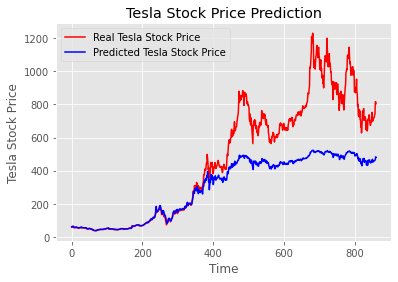

In [13]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)
# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)
# store the original vals for plotting the predictions
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)
# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))
# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

# plot the results
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()